In [1149]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import re
import folium
import seaborn as sn

import gensim
from gensim import corpora
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
# import jellyfish
import pyLDAvis
pyLDAvis.enable_notebook()
import pyLDAvis.gensim_models

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

import lightgbm
from sklearn import tree
import statsmodels.api as sm

In [1150]:
df = pd.read_parquet('_df_for_modeling.parquet')
def data_cleanup(df):

    df.dropna(how='all', axis=1, inplace=True) #drop empty cols

    number_looking_strings = ['id', 'scrape_id', 'host_id']
    for col in number_looking_strings:
        df[col] = df[col].astype("string")

    df['host_response_rate'] = df['host_response_rate'].str.replace("%","").astype(float)/100 #previously a percentage as a string
    df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace("%","").astype(float)/100 #previously a percentage as a string
    df['price'] = df['price'].str.replace(r'[$,]',"").astype(float) #previosuly represented as a string

    date_cols = ['last_scraped', 'host_since', 'calendar_last_scraped', 'first_review', 'last_review']
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], format=r'%Y-%m-%d')

    for col in df.columns:
        if df[col][0] == "f" or df[col][0] == "t": #if first record is "t" or "f" we're going to convert to bool - still should spot check after just incase first record of bool is null
            df[col] = df[col].str.replace("f", "0")
            df[col] = df[col].str.replace("t", "1")
            try: ## int can't hold nulls so if the conversion fails due to a value error, convert to float instead
                df[col] = df[col].astype(int)
            except:
                df[col] = df[col].astype(float)


    remaining_string_cols = df.select_dtypes(include=["object"]).columns #all remaining object columns are strings so I'm explicitly setting them to be
    for col in remaining_string_cols:
        df[col] = df[col].astype('string')

    list_string_cols = ['host_verifications', 'amenities'] #these 2 columns are string lists so I'm converting them back to object just so I remember to handle them differently
    for col in list_string_cols:
        df[col] = df[col].astype('object')

    return df

df = data_cleanup(df)

C:\Users\Immig\AppData\Local\Temp\ipykernel_34256\2129636235.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  df['price'] = df['price'].str.replace(r'[$,]',"").astype(float) #previosuly represented as a string


In [1151]:
df['amenities'] = df['amenities'].apply(lambda x: ast.literal_eval(x))
df['amenities'] = df['amenities'].apply(lambda x: ' '.join(x))
df['amenities'] = df['amenities'].apply(lambda x: x.lower())

# no stemming, but remove stop words and special characters
df['amenities'] = df['amenities'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['amenities'] = df['amenities'].apply(lambda x:" ".join(re.findall(r'[\w]+',x)))


corpus = [lst.split() for lst in df['amenities']]
dictionary = corpora.Dictionary(corpus)
DFM = [dictionary.doc2bow(word_lst) for word_lst in corpus]


n_topics = 6
ldamodel = gensim.models.LdaMulticore(DFM,
                                    num_topics = n_topics,
                                    id2word = dictionary,
                                    passes = 20,
                                    workers=12,
                                    random_state=902)

lda_topic_assignment = [max(x,key=lambda item: item[1]) for x in ldamodel[DFM]]


vis = pyLDAvis.gensim_models.prepare(ldamodel,
                                     DFM,
                                     dictionary)


# add as a new feature to the df
df['amenity_topic'] = [val[0] for val in lda_topic_assignment]
df['amenity_topic'] = df['amenity_topic'].astype('string')
df.drop(columns=['amenities'], inplace=True)

vis

c:\Users\Immig\anaconda3\envs\dsba6211\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.067765  0.086955       1        1  39.788439
3      0.101158 -0.000187       2        1  26.633576
2      0.029974  0.021785       3        1  10.464190
0      0.034065  0.042845       4        1   8.490898
1      0.055625 -0.092838       5        1   7.911667
5     -0.153056 -0.058561       6        1   6.711231, topic_info=         Term          Freq         Total Category  logprob  loglift
32       free  12504.000000  12504.000000  Default  30.0000  30.0000
2       alarm  12097.000000  12097.000000  Default  29.0000  29.0000
110      crib   1462.000000   1462.000000  Default  28.0000  28.0000
24      dryer  11802.000000  11802.000000  Default  27.0000  27.0000
54    parking   9892.000000   9892.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
16     coffee    548.694607   7388.165627   Topic6  -4.0971   0.1013
29       fire    521.155545   6329.266784   Topic6  -4.1486   0.2045
60   premises    512.880126   6855.475861   Topic6  -4.1646   0.1086
44    kitchen    480.191987   6235.745598   Topic6  -4.2305   0.1375
74     washer    449.064959   5612.292847   Topic6  -4.2975   0.1758

[468 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
268       5  0.988421       0
165       1  0.005832       1
165       2  0.198288       1
165       3  0.067068       1
165       4  0.612359       1
...     ...       ...     ...
954       5  0.854945   works
256       2  0.004997   years
256       5  0.989340   years
704       4  0.668692  zogics
704       5  0.167173  zogics

[1174 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 3, 1, 2, 6])

In [1152]:
#drop columns with primarily unique values - this will take care of things like ids, urls, descriptions, etc
drop_list = []
string_cols = df.select_dtypes(include=["object","string"]).columns
for col in string_cols:
    if len(df[col].value_counts()) > 1000:
        drop_list.append(col)

print(drop_list, "getting dropped.")
df.drop(columns=drop_list, inplace=True)


#also drop neighborhood because there's a cleansed column with this
df.drop(columns=['neighbourhood'], inplace=True)

#also drop price as the feature 'avg_price' replaces it
df.drop(columns=['price'], inplace=True)

['id', 'listing_url', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_about', 'host_thumbnail_url', 'host_picture_url'] getting dropped.


In [1153]:
df['host_tenure'] = (df['last_scraped']-df['host_since']).dt.days

# some listings have no value for host_since leading to a null for host_tenure. Replace these with 0
df['host_tenure'] = df['host_tenure'].fillna(0).astype(int)

# Change host_location to be a binary, nashville or not nashville
df['host_location'] = df['host_location'].fillna(' ').apply(lambda x: 1 if "nashville" in x.lower() else 0) # host location is now a binary (1 if host is in Nashville, else 0)

In [1154]:
#drop dep_candidate and all variables similar to what was used to create it
drop_cols = []
for col in df.columns:
    if "review" in col:
        drop_cols.append(col)
    if "availability" in col:
        drop_cols.append(col)
    if "host" in col:
        drop_cols.append(col)
drop_cols.append("scrape_id") # not relevant
drop_cols.append("last_scraped") # used for host tenure calculation
drop_cols.append("host_since") # captured in host tenure
drop_cols.append("calendar_last_scraped") # used for host tenure calculation
print(drop_cols, "getting dropped")
df.drop(columns=drop_cols, inplace=True)

['host_since', 'host_location', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'host_tenure', 'scrape_id', 'last_scraped', 'host_since', 'calendar_last_scraped'] getting dropped


In [1155]:
# df.drop(columns=['host_neighbourhood'], inplace=True)
# df.drop(columns=['host_verifications'], inplace=True)
df.drop(columns=['property_type'], inplace=True)

In [1156]:
df.select_dtypes(include=["object","string"]).describe(include='all')

neighbourhood_cleansed        room_type bathrooms_text amenity_topic
count                    6863             6863           6861          6863
unique                     35                4             32             6
top               District 19  Entire home/apt         1 bath             4
freq                     1716             6256           2472          3680

In [1157]:
df['neighbourhood_cleansed'] = df['neighbourhood_cleansed'].str.replace('District ', '')
df.rename(columns={'neighbourhood_cleansed':'district'},inplace=True)

In [1158]:
df['bathrooms_text'].value_counts()

def clean_bathrooms(x):
    words = x.split()
    values= []
    for word in words:
        try:
            values.append(float(word))
        except:
            values.append(0)
    
    if x == "Half-bath":
        val = "1"
    elif max(values) == 0:
        val = "0"
    elif max(values) == 1:
        val = "1"
    elif max(values) <= 3:
        val = "2-3"
    else:
        val = ">3"
    
    if "shared" in x:
        val = "shared"
    
    return val

df['bathrooms_text'] = df['bathrooms_text'].fillna("-1").apply(clean_bathrooms)
df.rename(columns={'bathrooms_text':'baths'},inplace=True)


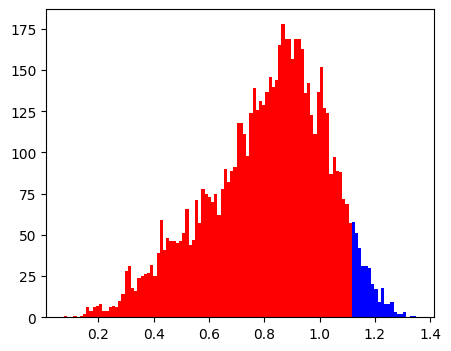

In [1159]:
#dep_var_cutoff = df['dep_candidate'].mean()
dep_var_cutoff = df['dep_candidate'].quantile(.95)
df['dep_candidate_cutoff_bool'] = (df['dep_candidate'] >= dep_var_cutoff).astype(int)
fig = plt.figure(figsize=(5,4))
plt.hist(df[df['dep_candidate']<=dep_var_cutoff][['dep_candidate']], bins=90, color='red')
plt.hist(df[df['dep_candidate']>dep_var_cutoff][['dep_candidate']], bins=20, color='blue')
plt.show()
df.drop(columns=['dep_candidate'], inplace=True)

In [1160]:
listings_1 = df[df["dep_candidate_cutoff_bool"]==1][["latitude", "longitude"]]
listings_0 = df[df["dep_candidate_cutoff_bool"]==0][["latitude", "longitude"]]


f = folium.Figure(width=800, height=600)
map = folium.Map(location=[df['latitude'].quantile(0.5), 
                        df['longitude'].quantile(0.5)],
                        zoom_start=11, 
                        control_scale=True,
                        tiles="cartodbpositron",
                        width=800, height=600).add_to(f)

for index, rowdata in listings_0.iterrows():
    folium.CircleMarker([rowdata["latitude"], rowdata["longitude"]],
                        radius=1, fill=False,
                        color = '#ff0f0f75').add_to(map) #red
for index, rowdata in listings_1.iterrows():
    folium.CircleMarker([rowdata["latitude"], rowdata["longitude"]],
                        radius=1, fill=False,
                        color = '#0202f0').add_to(map) # blue

map

In [1161]:
# Impute missing values using mode for categorical columns and median for numerical columns
cat_columns = df.select_dtypes(include=["string","object"]).columns
num_columns = df.select_dtypes(include="number").columns

# Replace missing values in the categorical columns with the most frequent value
for col in cat_columns:
        df[col].fillna("⍼", inplace=True)

# Replace missing values in the numerical columns with the median value
for col in num_columns:
    df[col].fillna(df[col].mean(), inplace=True)

# Separate target variable and feature columns
target = df["dep_candidate_cutoff_bool"]
features = df.drop(["dep_candidate_cutoff_bool"], axis=1)


features = pd.get_dummies(features, drop_first=True)

In [1162]:
features = features.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6863 entries, 0 to 6862
Data columns (total 55 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   latitude               6863 non-null   float64
 1   longitude              6863 non-null   float64
 2   accommodates           6863 non-null   int64  
 3   bedrooms               6863 non-null   float64
 4   beds                   6863 non-null   float64
 5   instant_bookable       6863 non-null   int32  
 6   avg_price              6863 non-null   float64
 7   avg_min_nights         6863 non-null   float64
 8   avg_max_nights         6863 non-null   float64
 9   district_10            6863 non-null   uint8  
 10  district_11            6863 non-null   uint8  
 11  district_12            6863 non-null   uint8  
 12  district_13            6863 non-null   uint8  
 13  district_14            6863 non-null   uint8  
 14  district_15            6863 non-null   uint8  
 15  dist

In [1163]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state = 999)

In [1164]:
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state = 999)
# Define tree model and model parameters to evalaute
params = {'criterion': ['entropy', 'gini'], 'max_depth': list(np.arange(3,12,1)), 'min_samples_split': list(np.arange(5,33,3))}
model_dtree = tree.DecisionTreeClassifier()

gscv_dtree = GridSearchCV(estimator=model_dtree, param_grid=params, verbose=1, cv=cv, n_jobs=-1, scoring='roc_auc', refit=True).fit(X_train, y_train)

# y_pred_dtree = gscv_dtree.predict_proba(X_test)
# print('roc_auc:', roc_auc_score(y_test, y_pred_dtree[:,1]))

print(gscv_dtree.best_params_)
print('Decision tree AUC-score:', gscv_dtree.score(X_test, y_test))
print(' ')



# Train a LightGBM model on the training data
model_lgbm = lightgbm.LGBMClassifier()
params = {'max_bin': [128, 255, 512], 'max_depth': list(np.arange(3,12,1)), 'min_data_in_leaf': list(np.arange(5,51,4))}
gscv_lgbm = GridSearchCV(estimator=model_lgbm, param_grid=params, verbose=1, cv=cv, n_jobs=-1, scoring='roc_auc', refit=True).fit(X_train, y_train)


# Evaluate the performance of the model
# print(classification_report(y_test, y_pred, digits=5))
print(gscv_lgbm.best_params_)
print('LGBM AUC-score:', gscv_lgbm.score(X_test, y_test))

Fitting 4 folds for each of 180 candidates, totalling 720 fits
{'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 23}
Decision tree AUC-score: 0.8206343678249878
 
Fitting 4 folds for each of 324 candidates, totalling 1296 fits
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
{'max_bin': 512, 'max_depth': 5, 'min_data_in_leaf': 49}
LGBM AUC-score: 0.8713141397724635


In [1165]:
list(np.arange(5,51,4)) 

[5, 9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49]

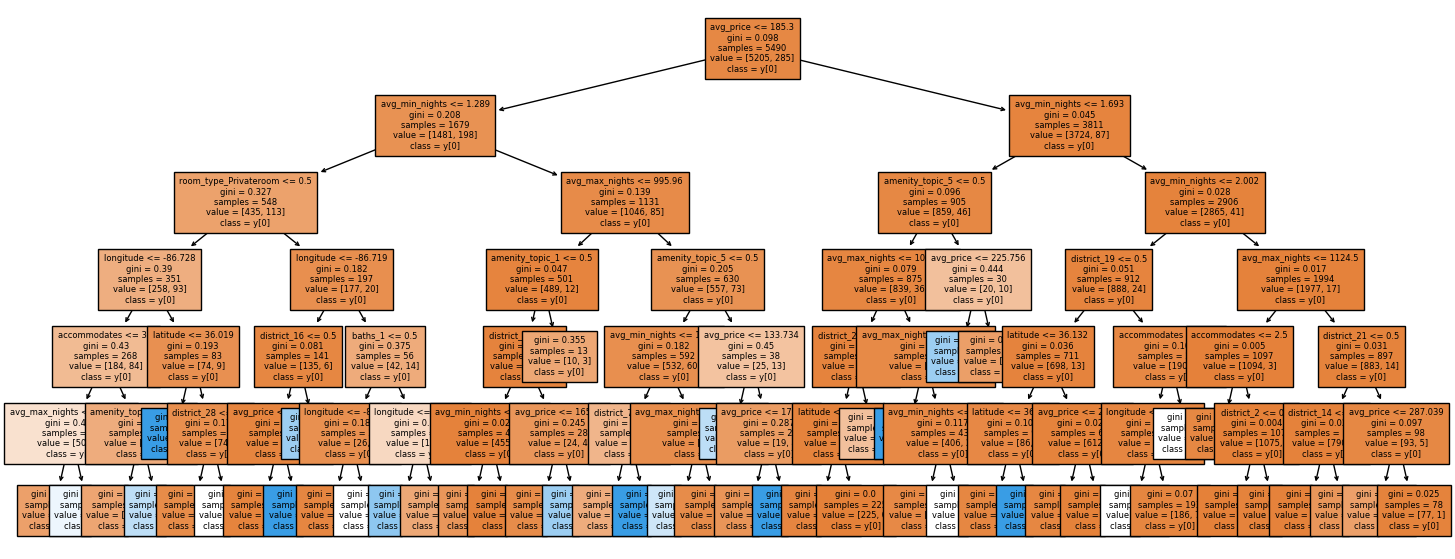

In [1166]:
# refit tree on entire train with the best parameters
refit_dtree = tree.DecisionTreeClassifier(criterion = gscv_dtree.best_params_['criterion'],
                                            max_depth = gscv_dtree.best_params_['max_depth'],
                                            min_samples_split =gscv_dtree.best_params_['min_samples_split'])
refit_dtree.fit(X_train, y_train)

plt.figure(figsize=[18,7])
tree.plot_tree(refit_dtree,
               proportion=False,
               feature_names=list(features.columns.values),
               class_names=True,
               filled=True,
               fontsize=6)
plt.show()

In [1167]:
# Train a LightGBM model on the training data
model_lgbm = lightgbm.LGBMClassifier(max_bin = gscv_lgbm.best_params_['max_bin'],
                                     max_depth = gscv_lgbm.best_params_['max_depth'], 
                                     min_data_in_leaf = gscv_lgbm.best_params_['min_data_in_leaf'])
model_lgbm.fit(X_train, y_train)

# Make predictions on the test data
y_pred_lgbm = model_lgbm.predict_proba(X_test)

# Evaluate the performance of the model
# print(classification_report(y_test, y_pred, digits=5))
print('roc_auc:', roc_auc_score(y_test, y_pred_lgbm[:,1]))

[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
roc_auc: 0.8713141397724635


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

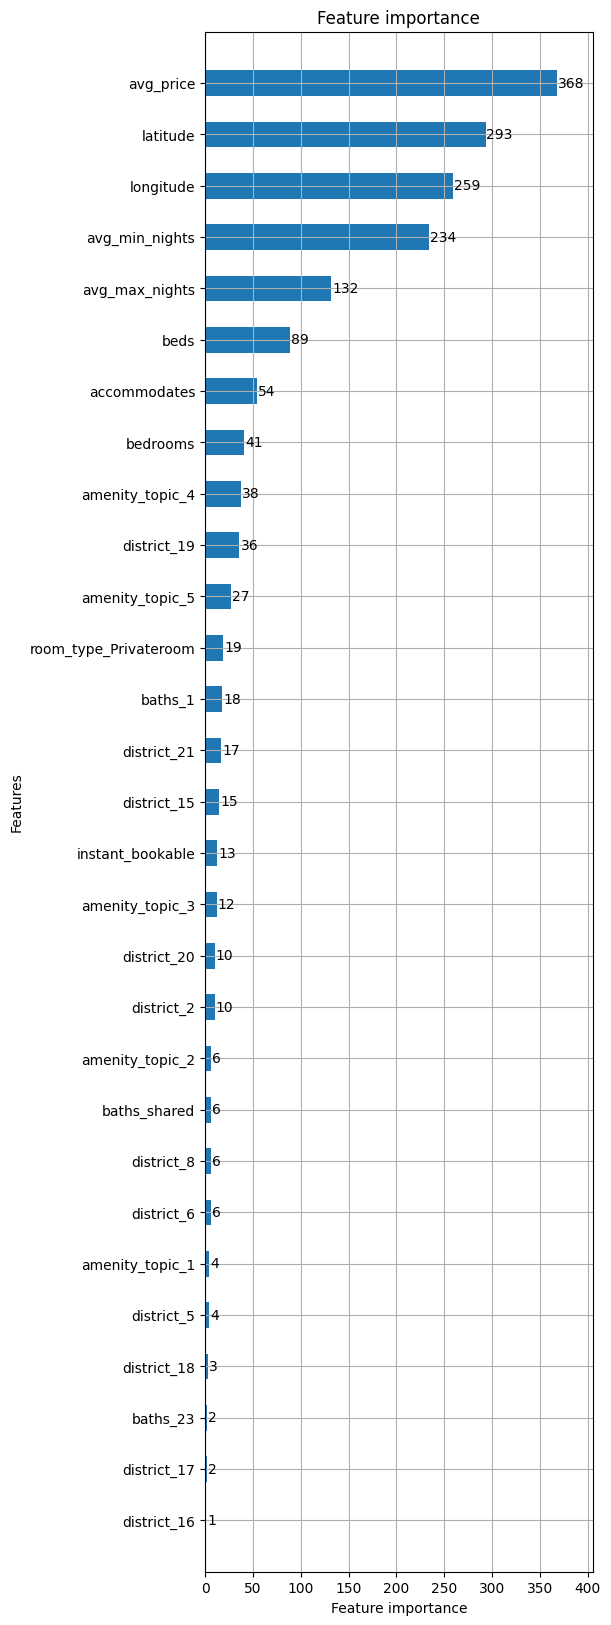

In [1168]:
plt.rcParams['figure.figsize'] = (5,20)
lightgbm.plot_importance(model_lgbm, height=0.5)

In [1169]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

check_vif_columns = df.select_dtypes(include=["number"]).columns

vif = [float(variance_inflation_factor(df[check_vif_columns].values,i)) for i in range(len(df[check_vif_columns].columns))]
vif_df = pd.DataFrame({"feature":df[check_vif_columns].columns, "VIF":vif})
vif_df


feature            VIF
0                   latitude  568622.050492
1                  longitude  568632.371305
2               accommodates      23.397931
3                   bedrooms      14.630341
4                       beds       8.962611
5           instant_bookable       2.864048
6                  avg_price       9.169313
7             avg_min_nights      10.145057
8             avg_max_nights       3.893090
9  dep_candidate_cutoff_bool       1.105555

In [1170]:
df_lr = df.drop(columns=['accommodates', 'bedrooms'])
check_vif_columns = df_lr.select_dtypes(include=["number"]).columns

vif = [float(variance_inflation_factor(df_lr[check_vif_columns].values,i)) for i in range(len(df_lr[check_vif_columns].columns))]
vif_df = pd.DataFrame({"feature":df_lr[check_vif_columns].columns, "VIF":vif})
vif_df

feature            VIF
0                   latitude  567871.614039
1                  longitude  567923.750688
2                       beds       3.629411
3           instant_bookable       2.830229
4                  avg_price       7.007594
5             avg_min_nights      10.029418
6             avg_max_nights       3.868784
7  dep_candidate_cutoff_bool       1.104216

In [1171]:
# corrMatrix = df_lr[check_vif_columns].corr()
# def gen_corr_heatmapvalues(x):
#     exponent = 3
#     if x == 1:  
#         return 0        
#     else:
#         return x*abs(x)**exponent

# corrMatrix_hmapval = corrMatrix.applymap(gen_corr_heatmapvalues)
# z = corrMatrix_hmapval/corrMatrix
# zz = z.max().max()

# plt.figure(figsize=(4,4))
# palplot = sn.diverging_palette(150, 275, s=100, l=45, n=19)

# sn.heatmap(corrMatrix_hmapval, vmin=-zz, vmax=zz, annot=corrMatrix, cmap=palplot, cbar=None)
# plt.show()

In [1172]:
df_lr['district'].value_counts()
df_lr.drop(columns=['latitude', 'longitude'], inplace=True)

In [1173]:
# Separate target variable and feature columns
# already have target from before
features_lr = df_lr.drop(["dep_candidate_cutoff_bool"], axis=1)

features_lr = pd.get_dummies(features_lr, drop_first=True)

features_lr = features_lr.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))


# Split the data into training and testing sets
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(features_lr, target, test_size=0.2, random_state = 999)

In [1174]:
# features_lr.hist(figsize=(25,20),bins=20)

In [1175]:
# drop extremely imbalanced dummy features
droplist = []
for col in features_lr.columns:
    if (features_lr[col].mean() < 0.03) & (features_lr[col].mean() >= 0):
        droplist.append(col)

print(droplist)
features_lr.drop(columns=droplist,inplace=True)

# Split the data into training and testing sets
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(features_lr, target, test_size=0.2, random_state = 999)

['district_10', 'district_11', 'district_12', 'district_13', 'district_14', 'district_16', 'district_20', 'district_22', 'district_23', 'district_24', 'district_25', 'district_26', 'district_27', 'district_28', 'district_29', 'district_3', 'district_30', 'district_31', 'district_32', 'district_33', 'district_34', 'district_35', 'district_4', 'district_8', 'district_9', 'room_type_Hotelroom', 'room_type_Sharedroom', 'baths_shared']


In [1176]:
model_lr = sm.Logit(y_train_lr, X_train_lr).fit()
print(model_lr.summary())

Optimization terminated successfully.
         Current function value: 0.166177
         Iterations 9
                               Logit Regression Results                              
Dep. Variable:     dep_candidate_cutoff_bool   No. Observations:                 5490
Model:                                 Logit   Df Residuals:                     5467
Method:                                  MLE   Df Model:                           22
Date:                       Fri, 09 Dec 2022   Pseudo R-squ.:                  0.1858
Time:                               22:41:36   Log-Likelihood:                -912.31
converged:                              True   LL-Null:                       -1120.6
Covariance Type:                   nonrobust   LLR p-value:                 1.610e-74
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
beds                      0.01

In [1177]:
pred_y_lr = model_lr.predict(X_test_lr)
print('roc_auc:', roc_auc_score(y_test_lr, pred_y_lr))

roc_auc: 0.7947398292185847


In [1178]:
# # statistcally insignificant variables (10% threshold)
# droplist = ['beds', 'instant_bookable', 'district_17', 'district_18', 'district_2', 'district_21',
#             'district_5', 'district_7', 'baths_1', 'baths_23', 'baths_3']

# features_lr.drop(columns=droplist,inplace=True)

# # Split the data into training and testing sets
# X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(features_lr, target, test_size=0.3)

In [1179]:
# model_lr = sm.Logit(y_train_lr, X_train_lr).fit()
# print(model_lr.summary())

In [1180]:
# pred_y_lr = model_lr.predict(X_test_lr)
# print('roc_auc:', roc_auc_score(y_test_lr, pred_y_lr))